# Tutorial Ptychographic imaging

# Ptychographic phase retrieval using Ptypy

### Tutor: Julio C. da Silva (Néel Institute CNRS, Grenoble, France) /  email: julio-cesar.da-silva@neel.cnrs.fr
#### Personal webpage: https://sites.google.com/view/jcesardasilva

##### Disclaimer: This notebook is intended for educational purposes only and should not be used for professional data analysis. For the latter, there are other more efficient and complete codes available.

# Ptypy - Ptychography for Python

<table class="tfo-notebook-buttons" align="center">

  <td>
    <a target="_blank" rel="noopener noreferrer"
href="https://ptycho.github.io/ptypy/index.html"><img src="https://ptycho.github.io/ptypy/_static/logo_100px.png" width="100%"/></a>
  </td>
</table>

<span style="color:blue"> **For the installation instruction of Ptypy, please click here: [Ptypy installation](https://ptycho.github.io/ptypy/rst/getting_started.html#installation)** </span>

In [3]:
import numpy as np
import ptypy
from ptypy import io
from ptypy import utils as u

We create the empty root parameter tree `p`. Then, we set `verbose_level` to `interactive` which is adapted for Jupyter notebooks since it gives a more condensed user output. 

In [4]:
## General parameter container
p = u.Param()
p.verbose_level = "interactive" # "info"						## Verbosity level

Now we need to create the subtree for input/output related paramters. For this particular example, we don't save any file and turn off autoplotting

In [5]:
p.run = "SiemensStar"						## Reconstruction identifier
## Global parameters for I/O
p.io = u.Param()
p.io.home = "./" 						## Base directory for all I/O
p.io.rfile = "recons/%(run)s/%(run)s_%(engine)s.ptyr" ## Reconstruction file name (or format string)
p.io.autosave = u.Param(active=False)  ## Auto-save options
p.io.autoplot = u.Param(active=False)  ## Plotting client parameters
p.io.interaction = u.Param(active=False)

Let's define the subtree for the scan parameters

In [6]:
## Scan parameters
p.scans = u.Param() ## param container for instances of scan parameters
p.scans.FAMEPIX = u.Param()
p.scans.FAMEPIX.name = "Full" #"BlockFull"  or "Full"
p.scans.FAMEPIX.propagation = "farfield"  ## Propagation type: "nearfield" or "farfield"

Now, we declared where the data is

In [7]:
# Data parameters
p.scans.FAMEPIX.data= u.Param() ## Data preparation parameters
p.scans.FAMEPIX.data.name = "PtydScan" ## Name of the PtyScan subclass to use
p.scans.FAMEPIX.data.source = "file" ## Describes where to get the data from.
p.scans.FAMEPIX.data.dfile = "SiemensStar.ptyd" ## Prepared data file path

We also have to tell how the illumination is

In [8]:
### calculation of the effective distance (Fresnel Scaling Theorem)
ptydfile=io.h5read('SiemensStar.ptyd','info')['info']
sx = ptydfile['sx']
focus_position = ptydfile['sx0']
z12 = ptydfile['distance']
z1 = np.abs(sx-focus_position)
z2 = z12-z1
dist_parallel = z1*z2/z12

# Illumination parameters
p.scans.FAMEPIX.illumination = u.Param()
p.scans.FAMEPIX.illumination.aperture = u.Param() ## Beam aperture parameters
p.scans.FAMEPIX.illumination.aperture.form = "rect" ## One of None, 'rect' or 'circ'
p.scans.FAMEPIX.illumination.aperture.size = 120e-6 ## Aperture width or diameter
p.scans.FAMEPIX.illumination.propagation=u.Param() ## Parameters for propagation 
p.scans.FAMEPIX.illumination.propagation.parallel = dist_parallel
p.scans.FAMEPIX.illumination.propagation.focussed = 0.1 
p.scans.FAMEPIX.illumination.model = None
p.scans.FAMEPIX.illumination.recon = None

Since the illumination can suffer from partial coherence effects, we decompose the probe in orthogonal modes to try to take the effects into account

In [19]:
p.scans.FAMEPIX.illumination.diversity = u.Param()
p.scans.FAMEPIX.illumination.diversity.power = 0.1
p.scans.FAMEPIX.illumination.diversity.noise = (1,2)
## coherence parameters
p.scans.FAMEPIX.coherence = u.Param()
p.scans.FAMEPIX.coherence.num_probe_modes = 3 ## Number of probe modes
p.scans.FAMEPIX.coherence.num_object_modes = 1 ## Number of object modes

We can also initialize the object function

In [20]:
## Object initiation parameters
p.scans.FAMEPIX.sample= u.Param() ## initial object modelization parameters
p.scans.FAMEPIX.sample.model = None ## None, 'recon', 'stxm'
p.scans.FAMEPIX.sample.recon = None
p.scans.FAMEPIX.sample.fill = 1.0 + 1j * 0.0 # Default fill value

Finally, we need to define one (or more) reconstruction engines which specify which ptychographic algorithm(s) should be used in the reconstruction. 

In [21]:
p.engines = u.Param()

## First engine = DM
p.engines.engine00 = u.Param()
p.engines.engine00.name = "DM"   ## Engine name
p.engines.engine00.numiter = 100         
p.engines.engine00.numiter_contiguous = 1       
p.engines.engine00.probe_support = None        
p.engines.engine00.alpha = 1                     
p.engines.engine00.probe_update_start = 2         
p.engines.engine00.update_object_first = True     
p.engines.engine00.overlap_converge_factor = 0.02 
p.engines.engine00.overlap_max_iterations = 100   
p.engines.engine00.probe_inertia = 0.01           
p.engines.engine00.object_inertia = 0.1           
p.engines.engine00.fourier_relax_factor = 0.02    
p.engines.engine00.obj_smooth_std = 5            
p.engines.engine00.clip_object = (0.,1.2)    

## Second engine = ML
p.engines.engine01 = u.Param()  
p.engines.engine01.name = 'ML'  ## Engine name
p.engines.engine01.numiter = 30         
p.engines.engine01.numiter_contiguous = 1        
p.engines.engine01.ML_type = "gaussian"             
p.engines.engine01.probe_support = None          
p.engines.engine01.floating_intensities = True   
p.engines.engine01.intensity_renormalization = 1 
p.engines.engine01.smooth_gradient = 1          
p.engines.engine01.scale_precond = True          
p.engines.engine01.probe_update_start = 2        

At the end of our script (notebook) we can create a `ptypy.core.Ptycho` object by passing the parameter tree `p` and `level=5` which initialises everything and starts the reconstruction.

In [22]:
P = ptypy.core.Ptycho(p,level=5)

Full: loading data for scan FAMEPIX (175 diffraction frames, 525 PODs, 1 probe(s) and 1 object(s))
Full: loading data for scan FAMEPIX (reformatting probe/obj/exit)
Full: loading data for scan FAMEPIX (initializing probe/obj/exit)
DM: initializing engine
DM: preparing engine
DM: Iteration # 100/100 :: Fourier 3.14e+01, Photons 8.59e-01, Exit 1.19e+00
ML: initializing engine
ML: preparing engine
ML: Iteration # 30/30 :: Fourier 0.00e+00, Photons 7.52e-01, Exit 0.00e+00
==== This reconstruction relied on the following work ==========================
The Ptypy framework:
    Enders B. and Thibault P., "A computational framework for ptychographic reconstructions" Proc. Royal Soc. A 472 (2016) 20160640, doi: 10.1098/rspa.2016.0640.
The difference map reconstruction algorithm:
    Thibault et al., "Probe retrieval in ptychographic coherent diffractive imaging" Ultramicroscopy 109 (2009) 338, doi: 10.1016/j.ultramic.2008.12.011.
The maximum likelihood reconstruction algorithm:
    Thibault P.

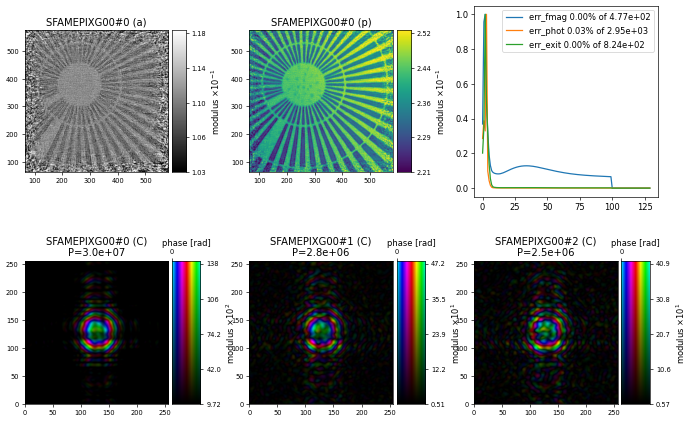

In [26]:
import os
import ptypy.utils.plot_client as pc
ptyr_filename = os.path.join(p.io.home, "recons/SiemensStar/SiemensStar_ML.ptyr")
#layout = pc.TEMPLATES["weak"]
layout = pc.TEMPLATES["jupyter"]
fig = pc.figure_from_ptyr(ptyr_filename, pars=layout)